In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FuncFormatter, LogLocator, NullFormatter

# Publisher-friendly text in vector PDFs
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"]  = 42

# Global style knobs (safe defaults)
matplotlib.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans", "DejaVu Sans", "Arial"],
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.linewidth": 1.2,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
})


In [2]:
CFG = {
    "ROOT": Path("."),

    # folders for KD groups (5 runs each)
    "KD_GROUPS": {
        "FEATURE":   [f"FEATURE/MODEL {i}" for i in range(1, 6)],
        "RESPONSE":  [f"RESPONSE/MODEL {i}" for i in range(1, 6)],
        "RELATION":  [f"RELATION/MODEL {i}" for i in range(1, 6)],
    },

    # baselines (single each)
    "BASELINES": {
        "Teacher":      "BASE/TEACHER",
        "Student":      "BASE/STUDENT",
        "Traditional":  "TRADITIONAL STUDENT",
    },

    # filenames inside each run folder
    "FILES": {
        "TELEMETRY": "telemetry.jsonl",
        "EVAL":      "eval.json",
        "EPT":       "ept.json",
    },

    # default ordering in plots
    "ORDER": ["Teacher", "Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"],

    # output dir
    "OUTDIR": Path("figures"),
}


In [3]:
def read_json(path: Path) -> dict:
    return json.loads(path.read_text(encoding="utf-8"))

def require(path: Path) -> Path:
    if not path.exists():
        raise FileNotFoundError(f"Missing: {path}")
    return path


In [4]:
def sanity_check(cfg: dict):
    root = cfg["ROOT"]
    files = cfg["FILES"]

    # Baselines
    for name, rel in cfg["BASELINES"].items():
        base = root / rel
        require(base)
        require(base / files["EVAL"])
        # telemetry/ept might not exist for all baselines, so don't require them unless you want:
        # require(base / files["TELEMETRY"])
        # require(base / files["EPT"])

    # KD groups (5 each)
    for kd, runs in cfg["KD_GROUPS"].items():
        for r in runs:
            run_dir = root / r
            require(run_dir)
            require(run_dir / files["EVAL"])
            # require(run_dir / files["TELEMETRY"])
            # require(run_dir / files["EPT"])

    print("✅ Sanity check passed: required eval.json files exist.")

sanity_check(CFG)


✅ Sanity check passed: required eval.json files exist.


In [5]:
# ==========================
# OM_perf_avg (DUMB) — TABLE
# ==========================
def extract_avg_accuracy(eval_path: Path,
                         metric_keys=("acc_norm,none", "acc,none")) -> float:
    """
    Avg accuracy across tasks from lm-eval-harness eval.json.
    Uses comma-style keys like 'acc_norm,none' and 'acc,none'.
    """
    obj = read_json(eval_path)

    # lm-eval-harness format often stores tasks under "results"
    res = obj["results"] if ("results" in obj and isinstance(obj["results"], dict)) else obj

    vals = []
    for task, block in res.items():
        if not isinstance(block, dict):
            continue

        found = None
        for k in metric_keys:
            v = block.get(k, None)
            if v is not None and isinstance(v, (int, float)):
                found = float(v)
                break

        if found is not None:
            vals.append(found)

    if not vals:
        sample_task = next(iter(res.keys())) if isinstance(res, dict) and res else None
        sample_keys = list(res[sample_task].keys())[:25] if sample_task else []
        raise KeyError(
            f"No accuracy keys {list(metric_keys)} found in {eval_path}. "
            f"Sample task: {sample_task}. Sample keys: {sample_keys}"
        )

    return float(np.mean(vals))





def build_om_summary(cfg: dict) -> pd.DataFrame:
    root = cfg["ROOT"]
    eval_name = cfg["FILES"]["EVAL"]

    rows = []

    # ---- Teacher (reference = 1.0) ----
    teacher_eval = root / cfg["BASELINES"]["Teacher"] / eval_name
    acc_teacher = extract_avg_accuracy(teacher_eval)

    rows.append({
        "Method": "Teacher",
        "mean": 1.0,
        "std": 0.0,
        "n": 1
    })

    # ---- Other baselines ----
    for label in ["Student", "Traditional"]:
        p = root / cfg["BASELINES"][label] / eval_name
        acc = extract_avg_accuracy(p)
        rows.append({
            "Method": label,
            "mean": acc / acc_teacher,
            "std": 0.0,
            "n": 1
        })

    # ---- KD groups (5 runs) ----
    for kd, runs in cfg["KD_GROUPS"].items():
        vals = []
        for r in runs:
            p = root / r / eval_name
            acc = extract_avg_accuracy(p)
            vals.append(acc / acc_teacher)

        arr = np.array(vals, dtype=float)
        rows.append({
            "Method": kd,
            "mean": float(arr.mean()),
            "std": float(arr.std()),
            "n": int(arr.size)
        })

    df = pd.DataFrame(rows)
    df["Method"] = pd.Categorical(df["Method"], categories=cfg["ORDER"], ordered=True)
    df = df.sort_values("Method").reset_index(drop=True)
    return df


# ---- BUILD TABLE ----
om_df = build_om_summary(CFG)
om_df


,Method,mean,std,n
0,Teacher,1.000000,0.000000,1
1,Student,0.857695,0.000000,1
2,Traditional,0.853027,0.000000,1
3,FEATURE,0.314668,0.006512,5
4,RESPONSE,0.801326,0.005581,5
5,RELATION,0.811444,0.004635,5


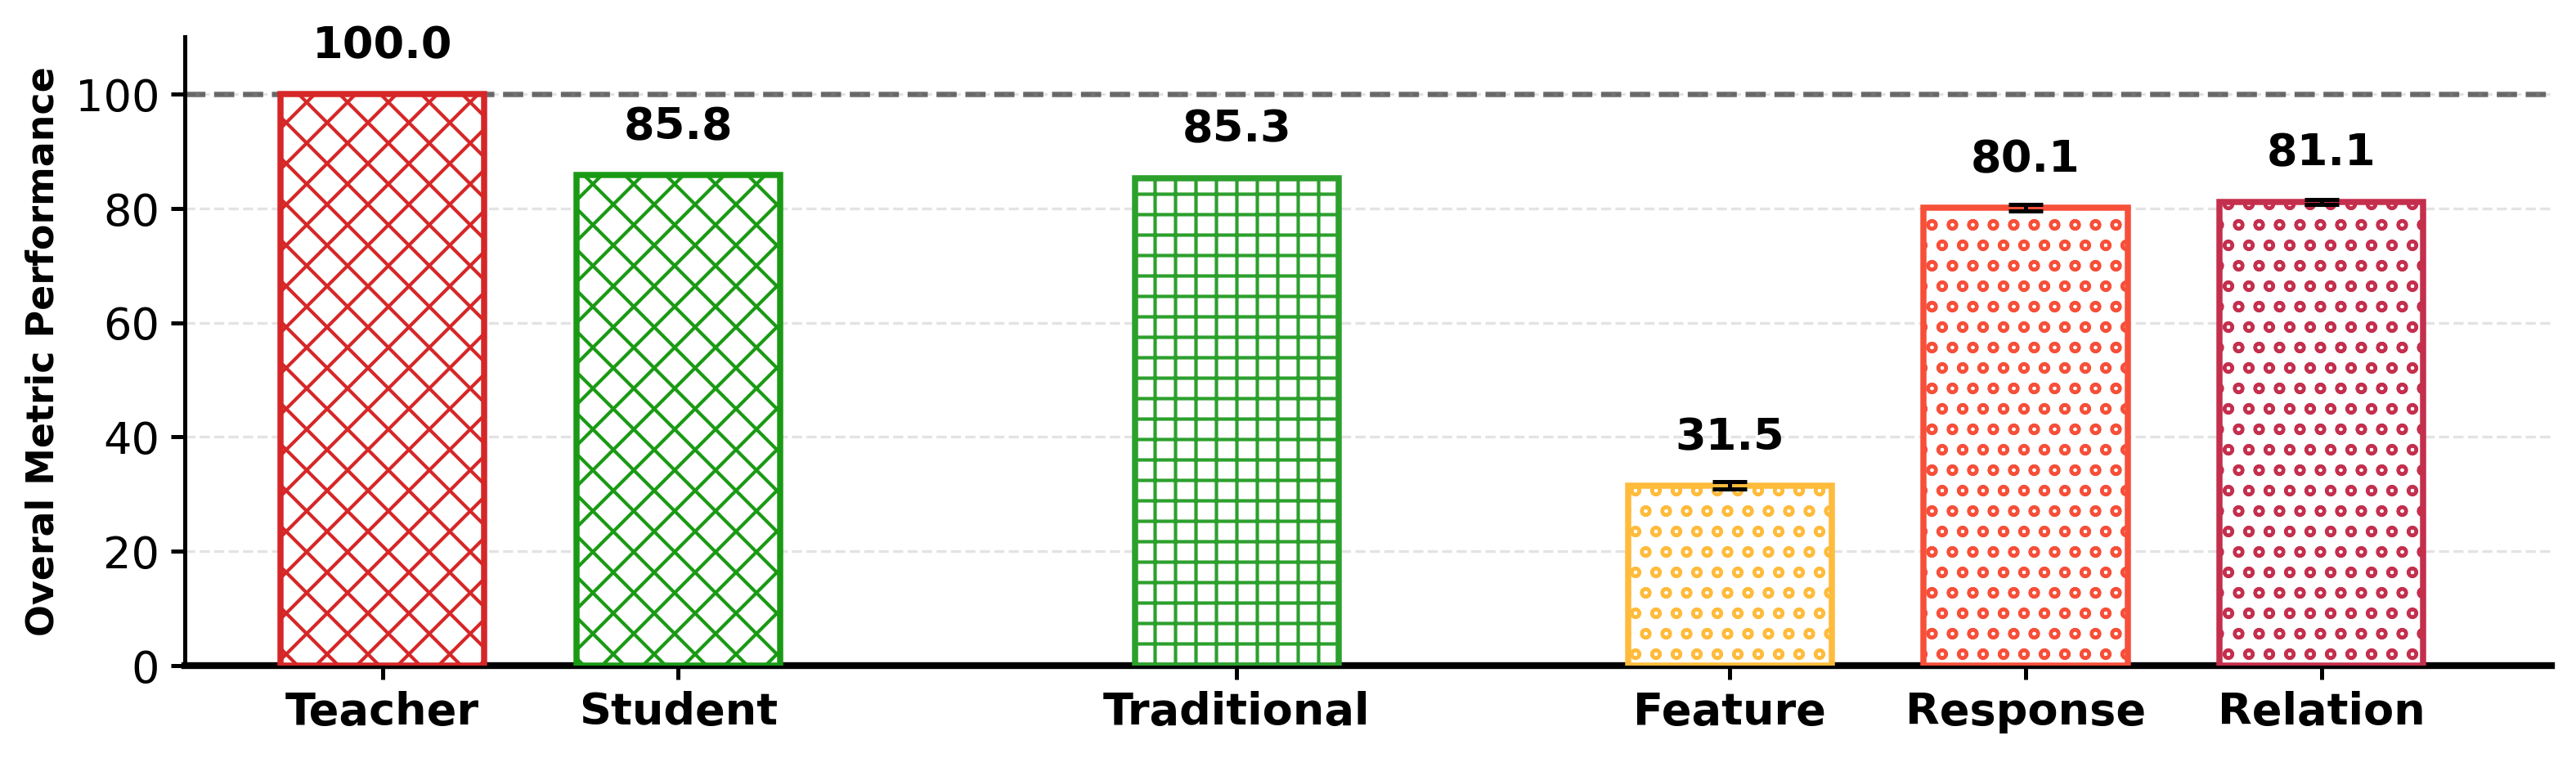

In [6]:
# ==========================
# OM_perf_avg — PLOT (paper-ready)
# ==========================

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"]  = 42

def plot_om_bars(om_df: pd.DataFrame, outdir: Path, basename: str = "om_perf_avg"):
    d = om_df.copy()
    d["Method"] = d["Method"].astype(str)

    order = d["Method"].tolist()  # already ordered by your build step
    means = d["mean"].to_numpy(dtype=float) * 100.0
    stds  = d["std"].to_numpy(dtype=float)  * 100.0

    # --- Spacing rules you wanted ---
    # base close, traditional separated, KD cluster tight
    xpos = {
        "Teacher": 0.0,
        "Student": 0.9,
        "Traditional": 2.6,
        "FEATURE": 4.1,
        "RESPONSE": 5.0,
        "RELATION": 5.9,
    }
    x = np.array([xpos[m] for m in order], dtype=float)

    # --- Styling (white fill + colored edges + hatches) ---
    STYLE = {
        "Teacher":     {"edge": "#d62728", "hatch": "xx"},
        "Student":     {"edge": "#1a9a14", "hatch": "xx"},
        "Traditional": {"edge": "#2ca02c", "hatch": "++"},
        "FEATURE":     {"edge": "#ffbb3b", "hatch": "oo"},
        "RESPONSE":    {"edge": "#f74f39", "hatch": "oo"},
        "RELATION":    {"edge": "#c42f4d", "hatch": "oo"},
    }

    fig, ax = plt.subplots(figsize=(10.6, 3.2), dpi=300)

    bar_w = 0.62
    for i, m in enumerate(order):
        st = STYLE.get(m, {"edge": "black", "hatch": ""})

        ax.bar(
            x[i], means[i],
            width=bar_w,
            color="white",
            edgecolor=st["edge"],
            linewidth=1.8,
            hatch=st["hatch"],
            zorder=3
        )

        # error bars only when std exists (KD)
        if stds[i] > 0:
            ax.errorbar(
                x[i], means[i], yerr=stds[i],
                fmt="none",
                ecolor="black",
                elinewidth=1.2,
                capsize=5,
                capthick=1.2,
                zorder=4
            )

        # numeric label on top (actual %)
        ax.annotate(
            f"{means[i]:.1f}",
            xy=(x[i], means[i]),
            xytext=(0, 8),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=13,
            fontweight="bold",
            zorder=5
        )

    # Teacher reference line
    ax.axhline(100.0, linestyle="--", linewidth=1.6, color="black", alpha=0.55, zorder=1)

    # Axes
    ax.set_ylabel("Overal Metric Performance", fontsize=11, fontweight="bold")
    ax.set_ylim(0, 110)
    ax.set_xlim(-0.6, 6.6)

    ax.set_xticks([xpos[k] for k in ["Teacher","Student","Traditional","FEATURE","RESPONSE","RELATION"]])
    ax.set_xticklabels(["Teacher","Student","Traditional","Feature","Response","Relation"],
                       fontsize=15, fontweight="bold")

    # Grid + spines
    ax.grid(True, axis="y", linestyle="--", alpha=0.35)
    ax.grid(False, axis="x")
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(2.0)

    ax.tick_params(axis="y", labelsize=13, width=1.2)
    ax.tick_params(axis="x", labelsize=13, width=1.2)

    fig.tight_layout()

    # Save best quality PDF
    outdir.mkdir(parents=True, exist_ok=True)
    fig.savefig(outdir / f"{basename}.pdf", bbox_inches="tight", dpi=600)  # dpi doesn't hurt, still vector
    fig.savefig(outdir / f"{basename}.svg", bbox_inches="tight")

    return fig, ax


# ---- RUN ----
fig, ax = plot_om_bars(om_df, CFG["OUTDIR"], basename="om_perf_avg")
plt.show()


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"]  = 42

def plot_bubble_by_model(
    df: pd.DataFrame,
    cfg=None,
):
    """
    Bubble scatter:
      x = model name (categorical)
      y = value_pct (0..100)
      bubble size = params_b (billions)

    df columns required:
      - model (str)
      - value_pct (float)  # already *100 if needed
      - params_b (float)   # e.g. 70, 8
    """
    if cfg is None:
        cfg = {}

    order   = cfg.get("ORDER", df["model"].tolist())
    figsize = cfg.get("FIGSIZE", (10.5, 3.4))
    dpi     = cfg.get("DPI", 300)
    ylim    = cfg.get("YLIM", (0, 100))
    title   = cfg.get("TITLE", None)
    ylabel  = cfg.get("YLABEL", "Score (%)")
    outdir  = cfg.get("OUTDIR", None)
    basename= cfg.get("BASENAME", "bubble_by_model")
    save    = cfg.get("SAVE", True)

    # bubble size scaling knobs (easy to tune)
    s_min = cfg.get("S_MIN", 140)   # size for smallest model
    s_max = cfg.get("S_MAX", 650)   # size for biggest model

    # color knobs (optional)
    col_teacher = cfg.get("COLOR_TEACHER", "#d62728")
    col_student = cfg.get("COLOR_STUDENT", "#1a9a14")
    edgecolor   = cfg.get("EDGECOLOR", "white")
    lw          = cfg.get("EDGE_LW", 1.6)

    d = df.copy()
    d["model"] = d["model"].astype(str)
    d["model"] = pd.Categorical(d["model"], categories=order, ordered=True)
    d = d.sort_values("model").reset_index(drop=True)

    x = np.arange(len(order))
    y = d["value_pct"].to_numpy(dtype=float)
    p = d["params_b"].to_numpy(dtype=float)

    # scale params -> bubble sizes
    pmin, pmax = float(np.min(p)), float(np.max(p))
    if pmax == pmin:
        sizes = np.full_like(p, (s_min + s_max) / 2.0)
    else:
        sizes = s_min + (p - pmin) * (s_max - s_min) / (pmax - pmin)

    # color teacher vs others (70B red, 8B green)
    # if you have only 70 and 8, this rule is perfect:
    colors = np.where(p >= 60, col_teacher, col_student)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    ax.scatter(
        x, y,
        s=sizes,
        c=colors,
        alpha=0.90,
        edgecolor=edgecolor,
        linewidth=lw,
        zorder=3
    )

    # label values above bubbles
    for xi, yi in zip(x, y):
        ax.annotate(
            f"{yi:.1f}",
            (xi, yi),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
            va="bottom",
            fontsize=13,
            fontweight="bold",
            zorder=4
        )

    # axes
    ax.set_xticks(x)
    ax.set_xticklabels(order, fontsize=15, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=16, fontweight="bold")
    ax.set_ylim(*ylim)

    ax.grid(True, axis="y", linestyle="--", alpha=0.35)
    ax.grid(False, axis="x")
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    if title:
        ax.set_title(title, fontsize=16, fontweight="bold", pad=10)

    # small legend for sizes (optional, simple)
    if cfg.get("SHOW_SIZE_LEGEND", True):
        handles = [
            ax.scatter([], [], s=s_min, c=col_student, edgecolor=edgecolor, linewidth=lw, label=f"{int(pmin)}B"),
            ax.scatter([], [], s=s_max, c=col_teacher, edgecolor=edgecolor, linewidth=lw, label=f"{int(pmax)}B"),
        ]
        ax.legend(handles=handles, loc="upper right", frameon=False, fontsize=12, title="Params", title_fontsize=12)

    fig.tight_layout()

    if save and outdir is not None:
        outdir = Path(outdir)
        outdir.mkdir(parents=True, exist_ok=True)
        fig.savefig(outdir / f"{basename}.pdf", bbox_inches="tight", dpi=600)
        fig.savefig(outdir / f"{basename}.svg", bbox_inches="tight")

    return fig, ax


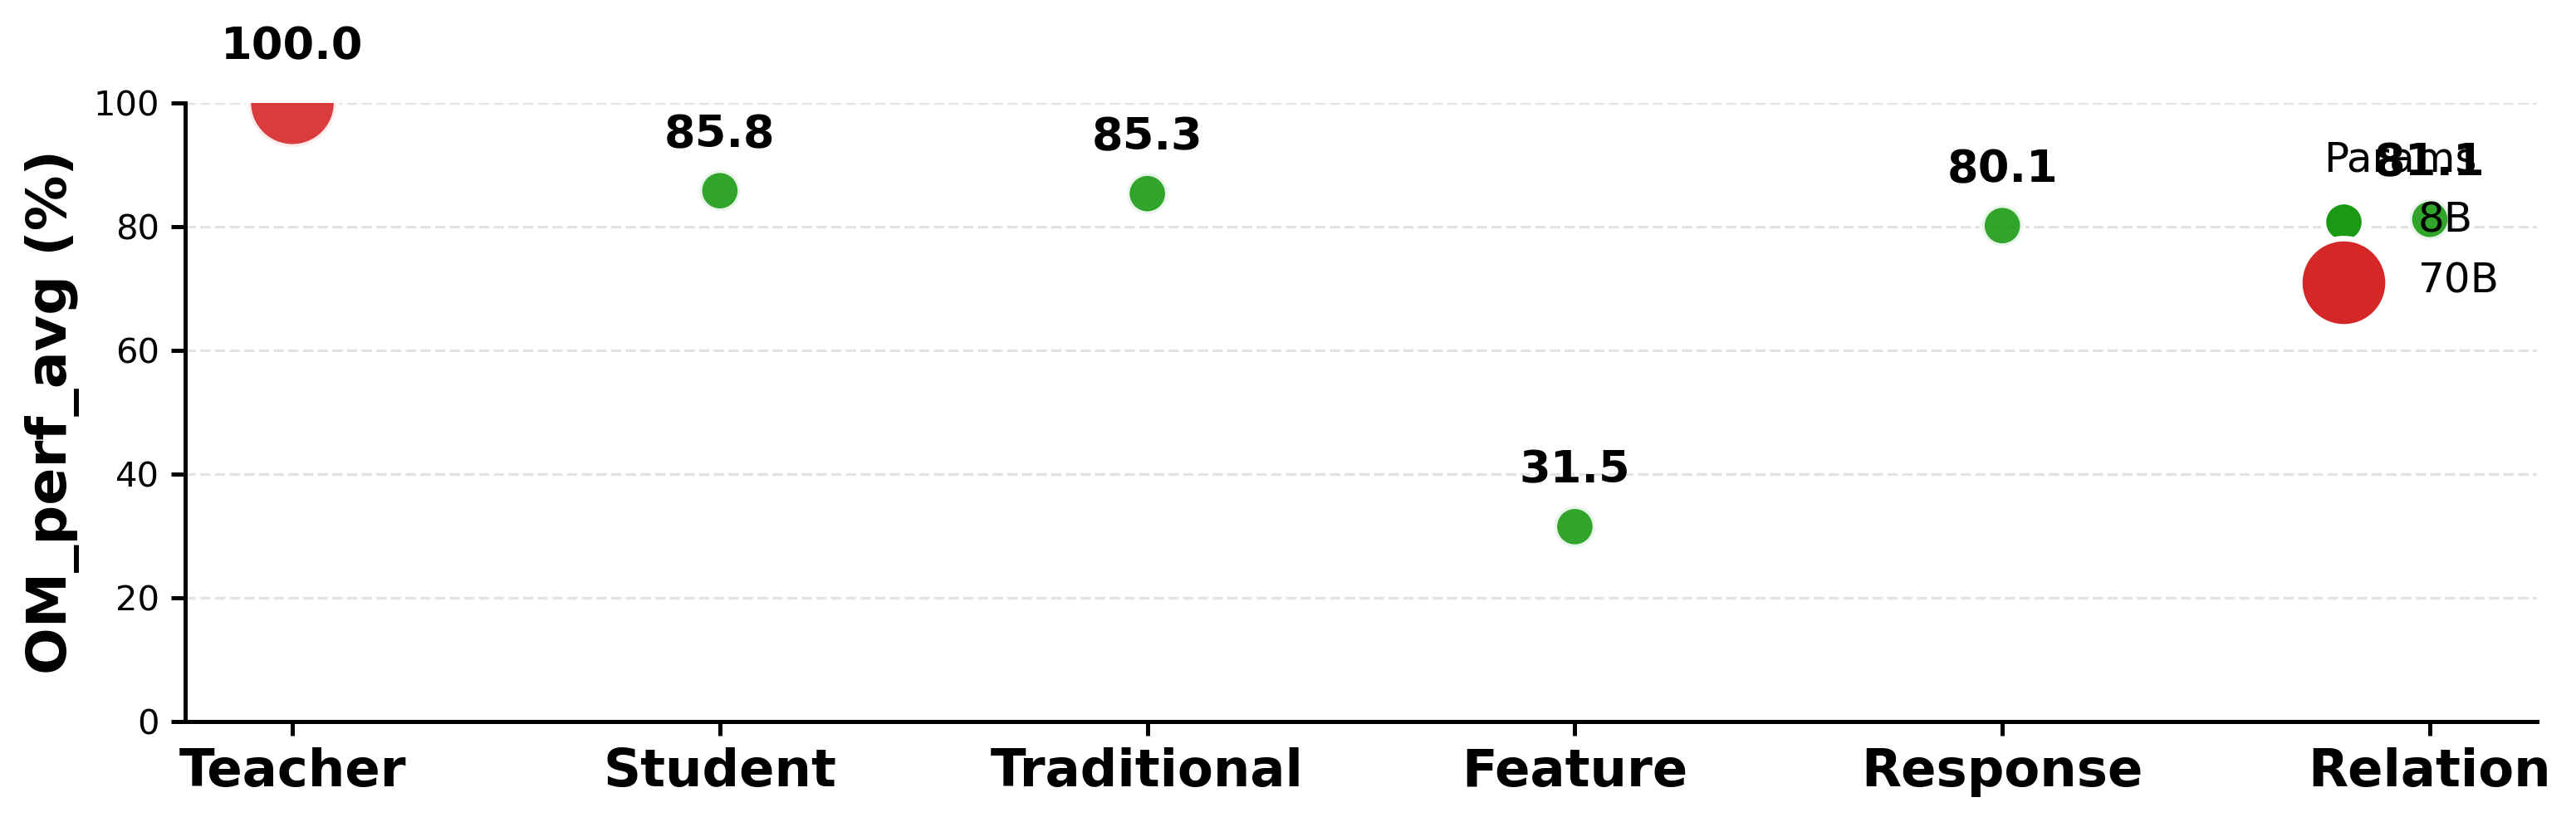

In [8]:
bubble_df = pd.DataFrame({
    "model": ["Teacher", "Student", "Traditional", "Feature", "Response", "Relation"],
    "value_pct": (om_df.set_index("Method")
                    .reindex(["Teacher","Student","Traditional","FEATURE","RESPONSE","RELATION"])["mean"]
                    .to_numpy() * 100.0),
    "params_b": [70, 8, 8, 8, 8, 8],
})

fig, ax = plot_bubble_by_model(
    bubble_df,
    cfg={
        "ORDER": ["Teacher", "Student", "Traditional", "Feature", "Response", "Relation"],
        "YLABEL": "OM_perf_avg (%)",
        "YLIM": (0, 100),
        "OUTDIR": "figures",
        "BASENAME": "om_bubbles_by_model",
        "SAVE": True,
        "SHOW_SIZE_LEGEND": True,
    }
)
plt.show()


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"]  = 42


def plot_om_with_table(om_df: pd.DataFrame, cfg=None):
    if cfg is None:
        cfg = {}

    ORDER = cfg.get(
        "ORDER",
        ["Teacher", "Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"]
    )

    FIGSIZE = cfg.get("FIGSIZE", (11, 4.8))
    DPI     = cfg.get("DPI", 300)
    DOTSIZE = cfg.get("DOTSIZE", 180)

    OUTDIR   = cfg.get("OUTDIR", "figures")
    BASENAME = cfg.get("BASENAME", "om_perf_plot")
    SAVE     = cfg.get("SAVE", True)

    # ---- Prepare data ----
    df = om_df.copy()
    df["Method"] = df["Method"].astype(str)
    df["Method"] = pd.Categorical(df["Method"], categories=ORDER, ordered=True)
    df = df.sort_values("Method").reset_index(drop=True)

    df["OM_pct"] = df["mean"] * 100.0

    x = np.arange(len(df))
    y = df["OM_pct"].to_numpy()

    # 70B teacher, 8B others
    colors = ["#d62728" if m == "Teacher" else "#2ca02c" for m in df["Method"]]

    # ---- Figure layout: plot + table ----
    fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
    gs = fig.add_gridspec(2, 1, height_ratios=[3.2, 1.2], hspace=0.05)

    ax = fig.add_subplot(gs[0])
    ax_table = fig.add_subplot(gs[1])
    ax_table.axis("off")

    # ---- Plot ----
    ax.plot(
        x, y,
        linestyle="--",
        linewidth=2.2,
        color="black",
        alpha=0.75,
        zorder=2
    )

    ax.scatter(
        x, y,
        s=DOTSIZE,
        c=colors,
        edgecolor="white",
        linewidth=1.8,
        zorder=3
    )

    # value labels
    for xi, yi in zip(x, y):
        ax.text(
            xi, yi + 2.0,
            f"{yi:.1f}",
            ha="center",
            va="bottom",
            fontsize=13,
            fontweight="bold"
        )

    # ---- Axes styling ----
    ax.set_xticks(x)
    ax.set_xticklabels(df["Method"], fontsize=14, fontweight="bold")
    ax.set_ylabel("Overall Metric Performance", fontsize=11, fontweight="bold")
    ax.set_ylim(0, 100)

    ax.grid(True, axis="y", linestyle="--", alpha=0.35)
    ax.grid(False, axis="x")
    ax.set_axisbelow(True)

    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.3)
    ax.spines["bottom"].set_linewidth(1.3)

    ax.tick_params(axis="y", labelsize=13)
    ax.tick_params(axis="x", labelsize=13)

    # ---- Legend (simple & clean) ----
    legend_handles = [
        plt.Line2D([0], [0], marker="o", color="w",
                   markerfacecolor="#d62728", markersize=10, label="Teacher (70B)"),
        plt.Line2D([0], [0], marker="o", color="w",
                   markerfacecolor="#2ca02c", markersize=10, label="Students (8B)")
    ]
    ax.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.18),   # ← moves legend ABOVE the axes
        ncol=2,
        frameon=False,
        fontsize=12
    )

    # # ---- Table (below plot) ----
    # table_df = df[["Method", "OM_pct"]].copy()
    # table_df["OM_pct"] = table_df["OM_pct"].map(lambda v: f"{v:.3f}")

    # table = ax_table.table(
    #     cellText=table_df.values,
    #     colLabels=["Method", "OM_perf_avg (%)"],
    #     loc="center",
    #     cellLoc="center",
    #     colLoc="center"
    # )

    # table.auto_set_font_size(False)
    # table.set_fontsize(13)
    # table.scale(1.0, 1.4)

    # bold header
    # for (r, c), cell in table.get_celld().items():
    #     cell.set_linewidth(0.6)
    #     if r == 0:
    #         cell.set_text_props(weight="bold")

    # ---- Save ----
    fig.tight_layout()

    if SAVE:
        from pathlib import Path
        out = Path(OUTDIR)
        out.mkdir(parents=True, exist_ok=True)
        

    return fig, ax


/var/folders/ql/566npwvs0g50jxk341zblhb80000gn/T/ipykernel_5263/1587541056.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


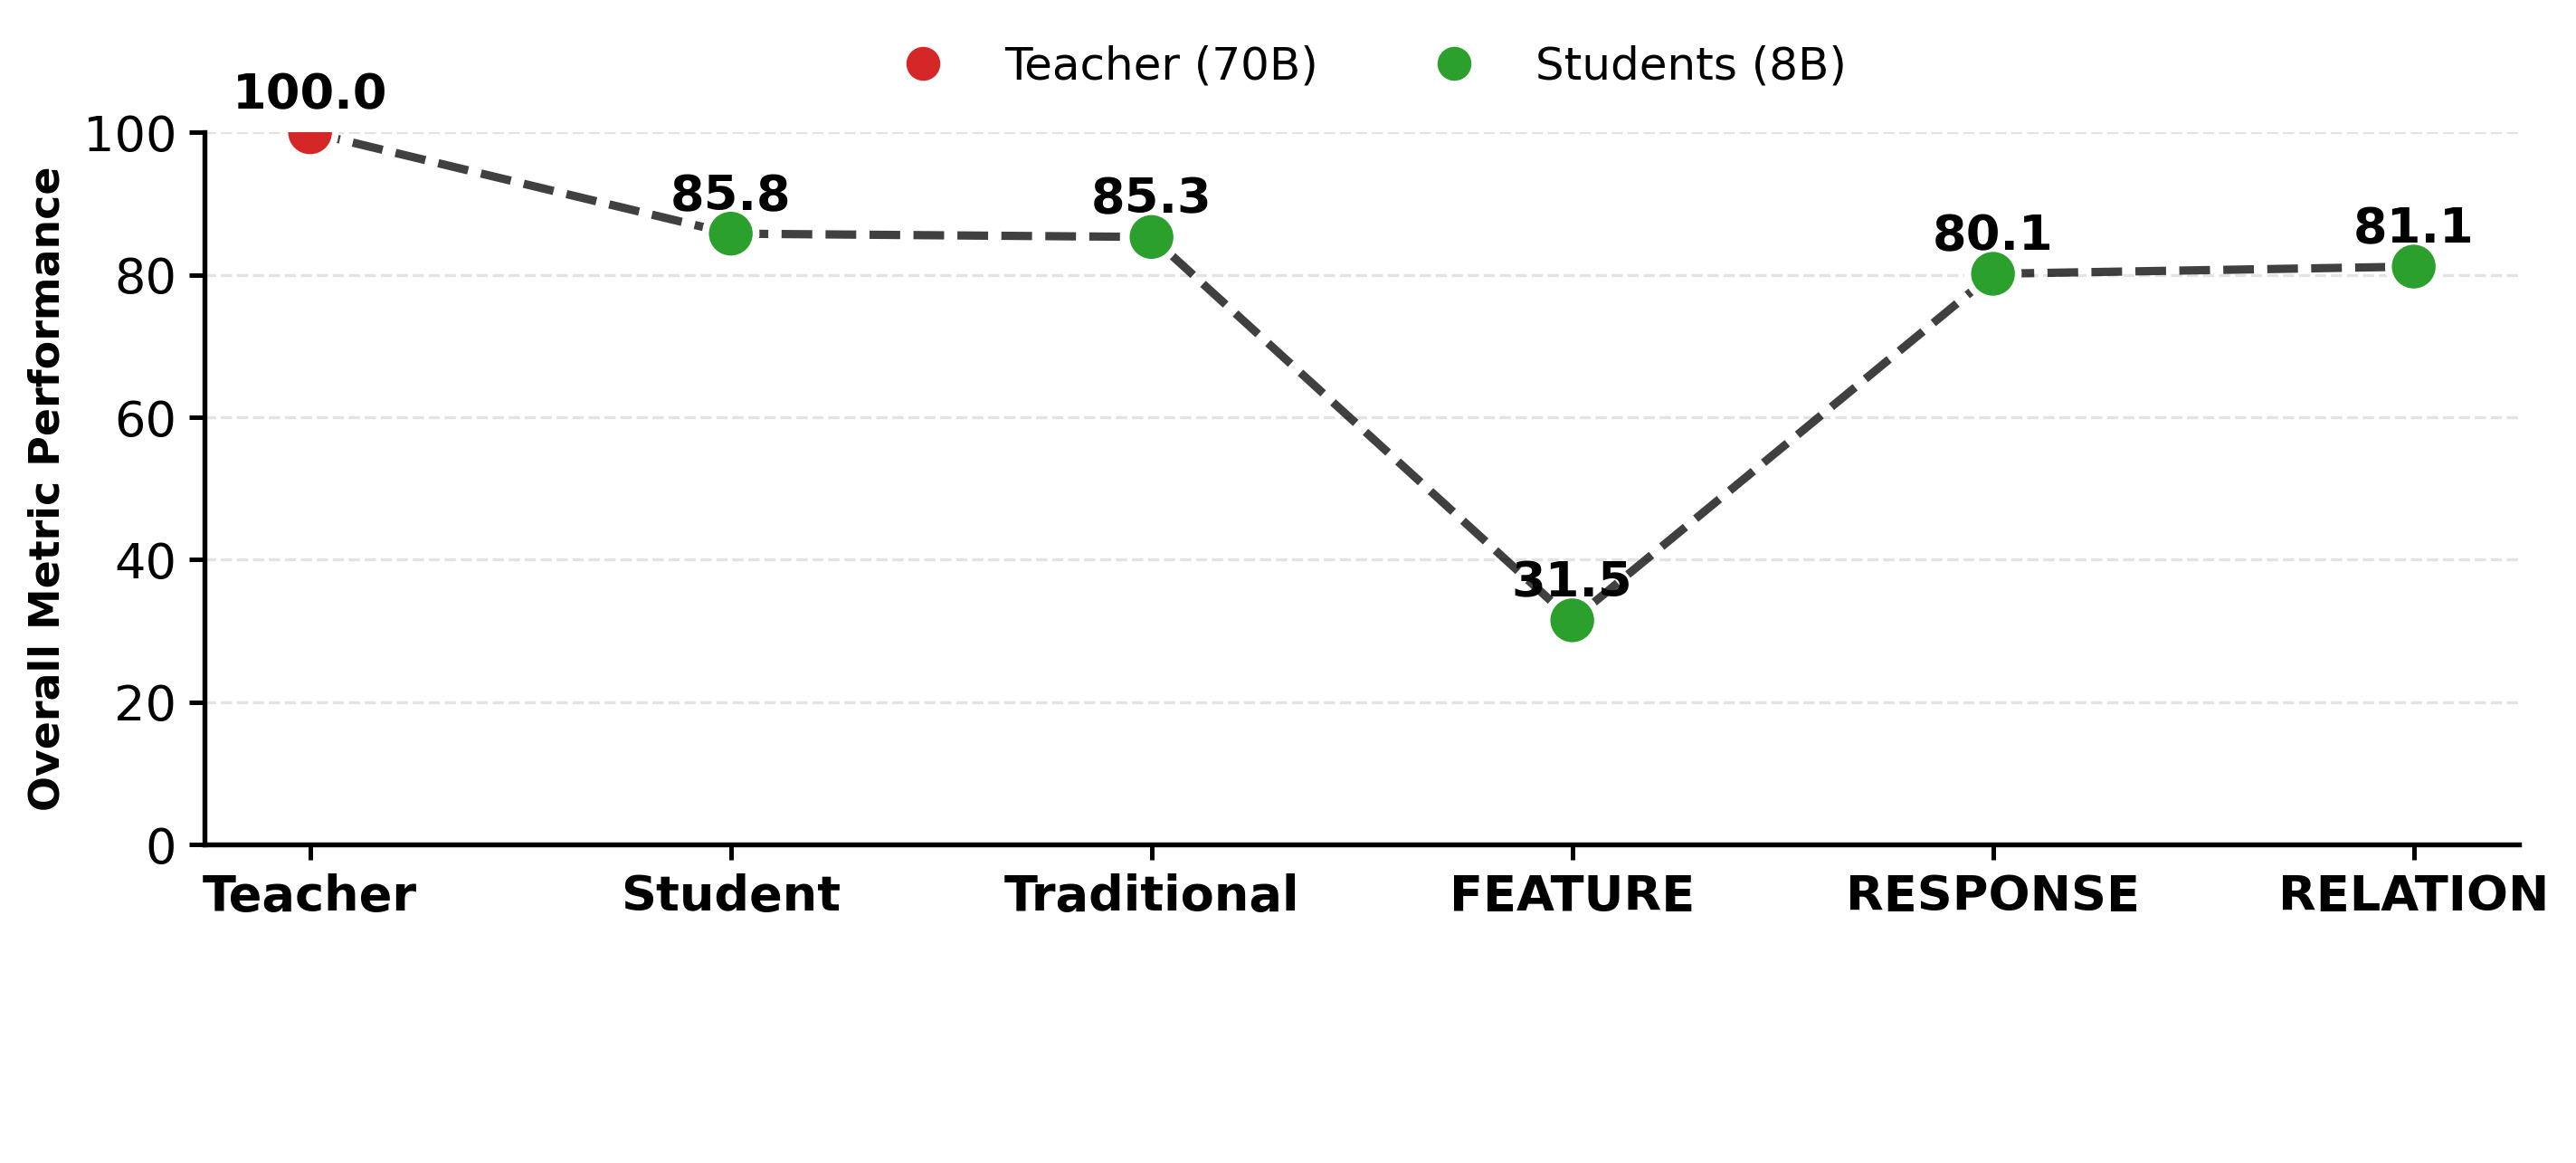

In [10]:
fig, ax = plot_om_with_table(
    om_df,
    cfg={
        "OUTDIR": "figures",
        "BASENAME": "om_perf",
        "SAVE": True,
    }
)

fig.savefig("figures/OMperf.pdf", bbox_inches="tight", dpi=600)
fig.savefig("figures/OMperf.svg", bbox_inches="tight")
plt.show()


/var/folders/ql/566npwvs0g50jxk341zblhb80000gn/T/ipykernel_5263/3176664582.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved: figures/om_perf.pdf
Saved: figures/om_perf.svg


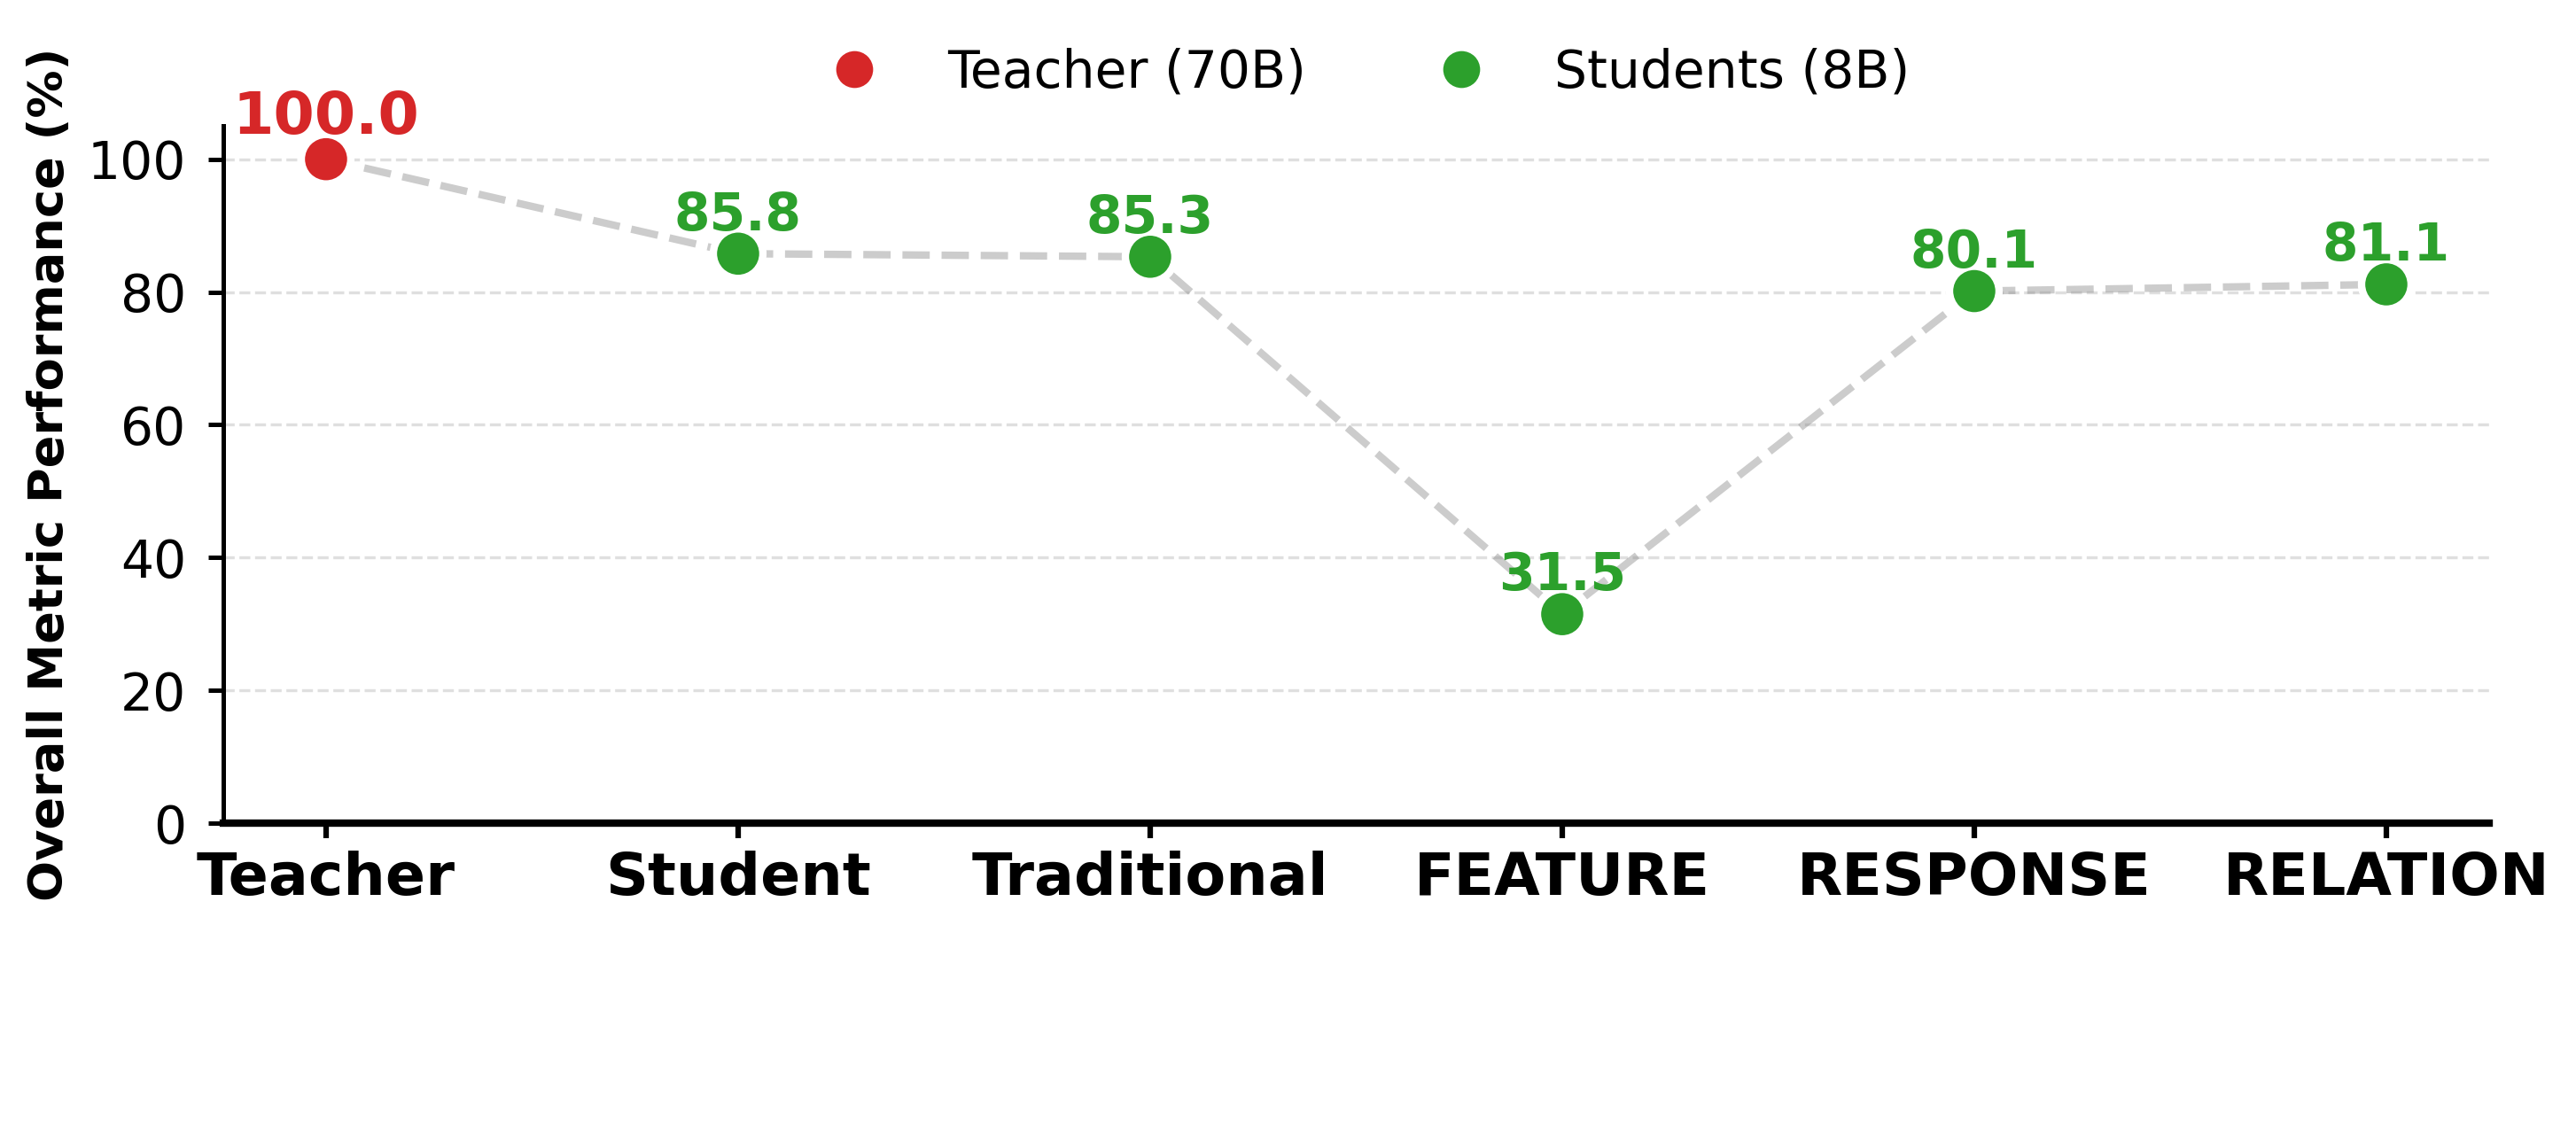

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

# ----------------------------
# EPT Systems Comparison Style
# ----------------------------
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

COLOR_TEACHER = "#d62728"
COLOR_STUDENT = "#2ca02c"
COLOR_TREND   = "gray"


def apply_ept_style():
    matplotlib.rcParams.update({
        # Fonts
        "font.size": 14,
        "axes.labelsize": 18,
        "axes.titlesize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 14,

        # Axes
        "axes.linewidth": 1.2,
        "axes.spines.top": False,
        "axes.spines.right": False,

        # Grid
        "grid.linestyle": "--",
        "grid.alpha": 0.4,

        # Lines
        "lines.linewidth": 2.0,

        # Figure
        "figure.dpi": 300,
        "savefig.dpi": 300,
    })


def style_axes_like_ept(ax, *, ypad=6):
    """Match the spine/tick/grid look used in your EPT plot."""
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.grid(False, axis="x")
    ax.set_axisbelow(True)

    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(2.0)  # slightly thicker baseline like your EPT plot
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.tick_params(axis="y", labelsize=14, width=1.2, pad=ypad)
    ax.tick_params(axis="x", labelsize=16, width=1.5)


def plot_om_with_table(om_df: pd.DataFrame, cfg=None):
    if cfg is None:
        cfg = {}

    apply_ept_style()

    ORDER = cfg.get("ORDER", ["Teacher", "Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"])
    FIGSIZE = cfg.get("FIGSIZE", (11, 4.8))
    DPI = cfg.get("DPI", 300)
    DOTSIZE = cfg.get("DOTSIZE", 180)

    OUTDIR = cfg.get("OUTDIR", "figures")
    BASENAME = cfg.get("BASENAME", "om_perf_plot")
    SAVE = cfg.get("SAVE", True)

    # ---- Prepare data ----
    df = om_df.copy()
    df["Method"] = df["Method"].astype(str)
    df["Method"] = pd.Categorical(df["Method"], categories=ORDER, ordered=True)
    df = df.sort_values("Method").reset_index(drop=True)

    df["OM_pct"] = df["mean"] * 100.0

    x = np.arange(len(df))
    y = df["OM_pct"].to_numpy(dtype=float)

    colors = [COLOR_TEACHER if m == "Teacher" else COLOR_STUDENT for m in df["Method"].astype(str)]

    # ---- Figure layout: plot + (optional) table slot ----
    fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
    gs = fig.add_gridspec(2, 1, height_ratios=[3.2, 1.2], hspace=0.05)

    ax = fig.add_subplot(gs[0])
    ax_table = fig.add_subplot(gs[1])
    ax_table.axis("off")

    # ---- Plot (match EPT aesthetics) ----
    ax.plot(
        x, y,
        linestyle="--",
        linewidth=2.0,
        color=COLOR_TREND,
        alpha=0.4,
        zorder=1
    )

    ax.scatter(
        x, y,
        s=DOTSIZE,
        c=colors,
        edgecolor="white",
        linewidth=2.0,
        zorder=3
    )

    # value labels (bold + color-coded like EPT)
    for xi, yi, m in zip(x, y, df["Method"].astype(str)):
        is_teacher = (m.lower() == "teacher")
        ax.text(
            xi, yi + 2.0,
            f"{yi:.1f}",
            ha="center",
            va="bottom",
            fontsize=16 if is_teacher else 14,
            fontweight="bold",
            color=COLOR_TEACHER if is_teacher else COLOR_STUDENT
        )

    # ---- Axes labels/ticks (match EPT sizing/weight) ----
    ax.set_xticks(x)
    ax.set_xticklabels(df["Method"].astype(str), fontsize=15, fontweight="bold", rotation=0)

    ax.set_ylabel("Overall Metric Performance (%)", fontsize=13, fontweight="bold")
    ax.set_ylim(0, 105)

    style_axes_like_ept(ax, ypad=6)

    # ---- Legend (EPT-like, no frame) ----
    legend_handles = [
        Line2D([0], [0], marker="o", color="none",
               markerfacecolor=COLOR_TEACHER, markeredgecolor="white",
               markeredgewidth=2, markersize=12, label="Teacher (70B)"),
        Line2D([0], [0], marker="o", color="none",
               markerfacecolor=COLOR_STUDENT, markeredgecolor="white",
               markeredgewidth=2, markersize=12, label="Students (8B)"),
    ]
    ax.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.18),
        ncol=2,
        frameon=False,
        fontsize=14
    )

    # ---- Save ----
    fig.tight_layout()

    if SAVE:
        from pathlib import Path
        out = Path(OUTDIR)
        out.mkdir(parents=True, exist_ok=True)
        fig.savefig(out / f"{BASENAME}.pdf", bbox_inches="tight", dpi=DPI)
        fig.savefig(out / f"{BASENAME}.svg", bbox_inches="tight")
        print(f"Saved: {out / f'{BASENAME}.pdf'}")
        print(f"Saved: {out / f'{BASENAME}.svg'}")

    return fig, ax


# ---- Usage ----
fig, ax = plot_om_with_table(
    om_df,
    cfg={
        "OUTDIR": "figures",
        "BASENAME": "om_perf",
        "SAVE": True,
        # Optional overrides:
        # "FIGSIZE": (11, 4.8),
        # "DOTSIZE": 180,
        # "DPI": 300,
    }
)

plt.show()
